In [7]:
# Run this code to make Jupyter print every
# printable statement and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# To visualize the data
import matplotlib.pyplot as plt

# Generic libraries
import seaborn as sns
import pandas as pd
import numpy as np

# Regression models
import sklearn
import scipy
from scipy.stats import t
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV #split the data into training and test
from sklearn.linear_model import LinearRegression #linear regression
from sklearn.preprocessing import PolynomialFeatures #for polynomial regression
from sklearn.metrics import r2_score, mean_squared_error

# 5-folds crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline


First of all, we import the dataset and we manipulate some data. We assign "category" type to categorical variables and we create dummy variables to treat them in a regression setting. Then, rows with NA "ExitRates" values are removed.

In [8]:
training_set_complete = pd.read_csv("data/training_set_online_shoppers_intention.csv")
all_categories_browser = list(range(1,14))
all_categories_traffic_type = list(range(1,21))
training_set_complete['Browser'] = training_set_complete['Browser'].astype('category').cat.set_categories(all_categories_browser)
training_set_complete['TrafficType'] = training_set_complete['TrafficType'].astype('category').cat.set_categories(all_categories_traffic_type)
training_set_complete = pd.get_dummies(training_set_complete, columns=['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend'], drop_first=False)
#training_set_complete['Weekend'] = np.where(training_set_complete['Weekend']=='True',1,0)
missing_values = training_set_complete[training_set_complete['ExitRates'].isna()]
training_set = training_set_complete[training_set_complete['ExitRates'].isna()==False]

In [9]:
X_train = training_set.drop(columns=['ExitRates','Revenue','Unnamed: 0'])
y_train = training_set['ExitRates']

### Variance selection
We apply variance selection to remove all the features with a very low variance.

In [10]:
from sklearn.feature_selection import VarianceThreshold

threshold = 0.001  # Soglia di varianza desiderata
variance_selector = VarianceThreshold(threshold=threshold)

# Applicazione della selezione della varianza sul dataset
X_train = X_train.loc[:, variance_selector.fit(X_train).get_support()]
columns_remaining = X_train.columns.tolist()
print(X_train.columns.tolist())
len(columns_remaining)

['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'PageValues', 'SpecialDay', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_6', 'OperatingSystems_8', 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_13', 'TrafficType_15', 'TrafficType_19', 'TrafficType_20', 'VisitorType_New_Visitor', 'VisitorType_Other', 'VisitorTyp

64

Plot of the histogram in order to have an idea of the distribution of the "ExitRates" variable. By looking at the plot, it seems quite asymmetrical, with peaks on the first values.

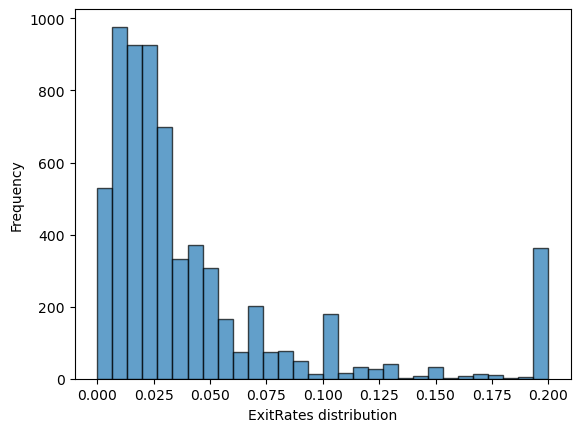

In [12]:
# Plotta l'istogramma
plot = plt.hist(np.array(y_train), bins=30, edgecolor='black', alpha=0.7)

# Aggiungi etichette e titolo al grafico
x_lab = plt.xlabel('ExitRates distribution')
y_lab = plt.ylabel('Frequency')

# Mostra il grafico
plt.show(plot)
plt.show(x_lab)
plt.show(y_lab)

## 1.2 Linear and polynomial regression

In [13]:
# AGGIUNGERE FEATURE SELECTION (Con CV) E LASSO!!


lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

mse_train = mean_squared_error(y_train, lin_reg.predict(X_train))
r2_train = r2_score(y_train, lin_reg.predict(X_train))

print("Mean Squared Error:", mse_train)
print("R-squared:", r2_train)

LinearRegression()

Mean Squared Error: 0.00031691698890822266
R-squared: 0.8633619179339873


Now we look at the coefficients:

In [15]:
# TOGLIERE??

# Create a dictionary to store feature-coefficient associations
feature_coefficients = {}

# Extract and store the coefficient for each feature
for feature_name, coefficient in zip(X_train.columns, lin_reg.coef_):
    feature_coefficients[feature_name] = coefficient

# Print the feature-coefficient associations
for feature, coefficient in feature_coefficients.items():
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature: Administrative, Coefficient: -0.0009001184214938163
Feature: Administrative_Duration, Coefficient: -2.1787930555285673e-06
Feature: Informational, Coefficient: 1.1724500832025955e-05
Feature: Informational_Duration, Coefficient: 8.575712691172386e-07
Feature: ProductRelated, Coefficient: -0.0001206282745879321
Feature: ProductRelated_Duration, Coefficient: 3.986370859972166e-07
Feature: BounceRates, Coefficient: 0.8576985048222211
Feature: PageValues, Coefficient: -0.00012848311790265854
Feature: SpecialDay, Coefficient: 0.006481827293356737
Feature: Month_Aug, Coefficient: -0.0007811124945140691
Feature: Month_Dec, Coefficient: 0.0007020626884916628
Feature: Month_Feb, Coefficient: -0.00016818459924514834
Feature: Month_Jul, Coefficient: 0.0007723301021593833
Feature: Month_June, Coefficient: 0.0053372550295690616
Feature: Month_Mar, Coefficient: -0.0008614687026464729
Feature: Month_May, Coefficient: -0.0009282131110282532
Feature: Month_Nov, Coefficient: -0.0002040779626236

Plot of the residuals for linear regression, to assess if our regression hypotheses are correct. The plot shows no particular pattern, residuals seem to be random distributed, so the assumptions are not violated.

<Figure size 500x500 with 0 Axes>

Text(0.5, 0, 'Predicted values')

Text(0, 0.5, 'Standardized residuals')

Text(0.5, 1.0, 'Residual Plot - Linear regression')

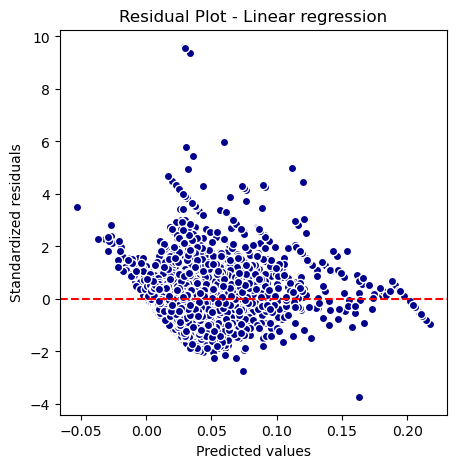

In [18]:
predicted_values = lin_reg.predict(X_train)
residuals = y_train - predicted_values
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(5, 5))
plt.scatter(predicted_values, standardized_residuals, color='darkblue', edgecolor='white')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Standardized residuals')
plt.title('Residual Plot - Linear regression')
plt.show()

Now we check if we may have a better model with polynomial features, performing a polynomial regression. The best solution, considering all the variables, is the linear one (degree = 1). We could expect this result also because the residual plot didn't show any particular pattern.

In [19]:
# METTERE QUESTO COME PRIMO CHUNCK

r2_scorer = make_scorer(r2_score, greater_is_better=True)

# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,3))}
              #'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5, refit=True)
cv.fit(X_train, y_train)
best_polynomial_model = cv.best_estimator_
print("Best Hyperparameters:", cv.best_params_)
print("Best R-squared Score:", cv.best_score_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2]},
             scoring=make_scorer(r2_score))

Best Hyperparameters: {'poly__degree': 1}
Best R-squared Score: 0.8596725126111544


Plot of the residuals for polynomial, to assess if our regression hypotheses are correct. The plot shows no particular pattern, residuals seem to be random distributed, so the assumptions are not violated.

<Figure size 500x500 with 0 Axes>

Text(0.5, 0, 'Predicted values')

Text(0, 0.5, 'Standardized residuals')

Text(0.5, 1.0, 'Residual Plot - Polynomial regression')

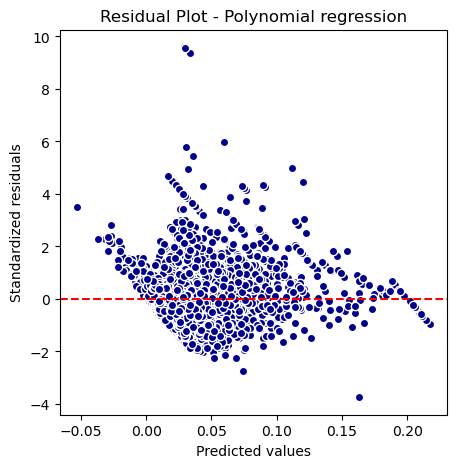

In [20]:
predicted_values = best_polynomial_model.predict(X_train)
residuals = y_train - predicted_values
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(5, 5))
plt.scatter(predicted_values, standardized_residuals, color='darkblue', edgecolor='white')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Standardized residuals')
plt.title('Residual Plot - Polynomial regression')
plt.show()

## 1.3 Improvements of linear regression

We now try to improve linear regression performance by using shrinkage methods (to improve accuracy) and feature selection (to improve interpretability).

### Ridge regression

The $R^2$ decreased with respect to the standard linear model. It is coherent, because all our coefficients are very small and Ridge regression is more appropriate when we have some high coefficients that we want to shrink near 0.

In [21]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

best_degree = 1
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0]  # Add more values if needed
}
best_degree = 2
pipeline = Pipeline([
    #('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', scaler),
    ('ridge', Ridge())  # Ridge estimator without specifying alpha
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['ridge__alpha']
best_estimator = grid_search.best_estimator_
print("Best alpha:", best_alpha)
print("Best coefficients:", best_estimator.named_steps['ridge'].coef_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 1.0, 10.0]})

Best alpha: 10.0
Best coefficients: [-2.96424925e-03 -3.68515747e-04  1.20284221e-05  1.16778849e-04
 -5.24521381e-03  6.66887541e-04  4.10884577e-02 -2.38730888e-03
  1.28589004e-03 -8.26430517e-05  3.66368468e-04  2.70559038e-05
  2.02504855e-04  8.58660089e-04 -1.89846621e-04 -2.60648639e-04
  5.89167970e-05 -2.99423576e-04 -3.30324065e-04  4.59801121e-04
  1.98109140e-03 -1.50371674e-04  4.96414632e-04 -2.55214869e-04
 -2.30899697e-04 -4.20583637e-04 -8.20462846e-04  6.14120341e-05
 -3.18248194e-04 -4.48863080e-04 -1.58460239e-04  7.26564647e-05
 -4.42871160e-05 -4.34526086e-04 -6.63262842e-04  1.43933172e-04
 -2.00877776e-04  2.77889831e-04 -5.88421757e-06 -4.92104783e-05
 -1.95872211e-04 -3.80738098e-04 -1.98069599e-04  3.20519295e-04
  1.91466386e-03  1.21562864e-04  2.05465183e-03  2.38785148e-04
  6.74029347e-04  6.42914205e-04  2.25812450e-05  2.97245529e-04
  1.07377524e-04  5.07909528e-04  5.28842012e-04  1.46112717e-03
  2.19846704e-04 -2.53147992e-04  3.17203834e-04 -1.56

In [22]:
best_model_ridge = grid_search.best_estimator_

mse_train = mean_squared_error(y_train, best_model_ridge.predict(X_train))
r2_train = r2_score(y_train, best_model_ridge.predict(X_train))

print("Best alpha:", best_alpha)
print("Best coefficients:", best_model_ridge.named_steps['ridge'].coef_)
print("Mean Squared Error:", mse_train)
print("R-squared:", r2_train)

Best alpha: 10.0
Best coefficients: [-2.96424925e-03 -3.68515747e-04  1.20284221e-05  1.16778849e-04
 -5.24521381e-03  6.66887541e-04  4.10884577e-02 -2.38730888e-03
  1.28589004e-03 -8.26430517e-05  3.66368468e-04  2.70559038e-05
  2.02504855e-04  8.58660089e-04 -1.89846621e-04 -2.60648639e-04
  5.89167970e-05 -2.99423576e-04 -3.30324065e-04  4.59801121e-04
  1.98109140e-03 -1.50371674e-04  4.96414632e-04 -2.55214869e-04
 -2.30899697e-04 -4.20583637e-04 -8.20462846e-04  6.14120341e-05
 -3.18248194e-04 -4.48863080e-04 -1.58460239e-04  7.26564647e-05
 -4.42871160e-05 -4.34526086e-04 -6.63262842e-04  1.43933172e-04
 -2.00877776e-04  2.77889831e-04 -5.88421757e-06 -4.92104783e-05
 -1.95872211e-04 -3.80738098e-04 -1.98069599e-04  3.20519295e-04
  1.91466386e-03  1.21562864e-04  2.05465183e-03  2.38785148e-04
  6.74029347e-04  6.42914205e-04  2.25812450e-05  2.97245529e-04
  1.07377524e-04  5.07909528e-04  5.28842012e-04  1.46112717e-03
  2.19846704e-04 -2.53147992e-04  3.17203834e-04 -1.56

Plot of the residuals for linear regression with Ridge, to assess if our regression hypotheses are correct. The plot shows no particular pattern, residuals seem to be random distributed, so the assumptions are not violated.

<Figure size 500x500 with 0 Axes>

Text(0.5, 0, 'Predicted values')

Text(0, 0.5, 'Standardized residuals')

Text(0.5, 1.0, 'Residual Plot - Linear regression with Ridge')

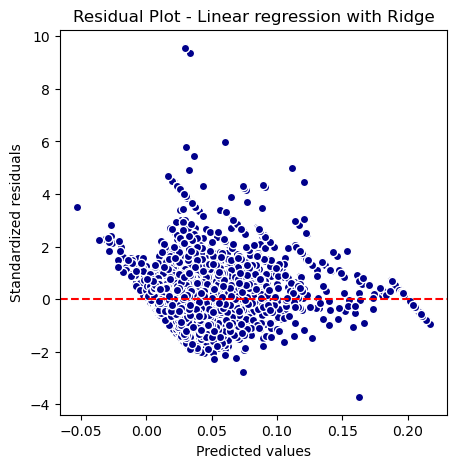

In [23]:
predicted_values = best_model_ridge.predict(X_train)
residuals = y_train - predicted_values
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(5, 5))
plt.scatter(predicted_values, standardized_residuals, color='darkblue', edgecolor='white')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Standardized residuals')
plt.title('Residual Plot - Linear regression with Ridge')
plt.show()

### Lasso

In [69]:
from sklearn.linear_model import Lasso
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

best_degree = 1
param_grid = {
    'lasso__alpha': [0.0005, 0.001, 0.01, 0.1, 1.0, 10.0]  # Add more values if needed
}
pipeline = Pipeline([
    #('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', scaler),
    ('lasso', Lasso())  # Ridge estimator without specifying alpha
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
best_alpha = grid_search.best_params_['lasso__alpha']
best_estimator = grid_search.best_estimator_
print("Best alpha:", best_alpha)
print("Best coefficients:", best_estimator.named_steps['lasso'].coef_)
np.count_nonzero(np.array(best_estimator.named_steps['lasso'].coef_))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.0005, 0.001, 0.01, 0.1, 1.0, 10.0]})

Best alpha: 0.0005
Best coefficients: [-3.08470361e-03 -8.46336327e-05 -0.00000000e+00 -0.00000000e+00
 -4.07679955e-03 -0.00000000e+00  4.10440150e-02 -2.08085000e-03
  7.40913558e-04 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.94537404e-04 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  7.23502262e-04 -4.39138916e-04  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  2.19439370e-04 -1.22414681e-03  4.63468960e-04 -2.75359391e-04
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  2.02661797e-04
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -2.

16

In [70]:
best_model_lasso = grid_search.best_estimator_

mse_train = mean_squared_error(y_train, best_model_lasso.predict(X_train_scaled))
r2_train = r2_score(y_train, best_model_lasso.predict(X_train_scaled))

print("Best alpha:", best_alpha)
print("Best coefficients:", best_model_lasso.named_steps['lasso'].coef_)
print("Mean Squared Error:", mse_train)
print("R-squared:", r2_train)

Best alpha: 0.0005
Best coefficients: [-3.08470361e-03 -8.46336327e-05 -0.00000000e+00 -0.00000000e+00
 -4.07679955e-03 -0.00000000e+00  4.10440150e-02 -2.08085000e-03
  7.40913558e-04 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.94537404e-04 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  7.23502262e-04 -4.39138916e-04  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  2.19439370e-04 -1.22414681e-03  4.63468960e-04 -2.75359391e-04
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  2.02661797e-04
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -2.

Plot of the residuals for linear regression with Lasso, to assess if our regression hypotheses are correct. The plot shows no particular pattern, residuals seem to be random distributed, so the assumptions are not violated.

<Figure size 500x500 with 0 Axes>

Text(0.5, 0, 'Predicted values - Linear regression with Lasso')

Text(0, 0.5, 'Standardized residuals')

Text(0.5, 1.0, 'Residual Plot')

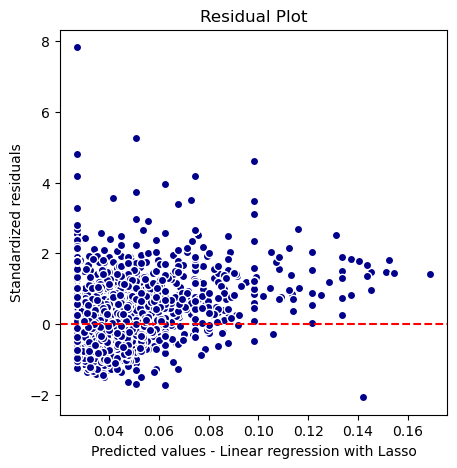

In [26]:
predicted_values = best_model_lasso.predict(X_train)
residuals = y_train - predicted_values
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(5, 5))
plt.scatter(predicted_values, standardized_residuals, color='darkblue', edgecolor='white')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted values - Linear regression with Lasso')
plt.ylabel('Standardized residuals')
plt.title('Residual Plot')
plt.show()

In [ ]:
coefficients_df = pd.DataFrame({
    #'Feature': X.columns,
    'Ridge Coefficients': best_model_ridge.named_steps['ridge'].coef_,
    'Lasso Coefficients': best_model_lasso.named_steps['lasso'].coef_
})

# Print the entire DataFrame to see the coefficients with the associated variables
coefficients_df

To perform an accurate evaluation of the models we compute the RMSE throug 5-cv. As we can see from the results, the linear regression shows a better score wrt ridge and lasso. 

In [ ]:
# Linear Regression
linear_reg_score = cross_val_score(lin_reg, X, y, cv=5, scoring='neg_mean_squared_error')
linear_reg_rmse = np.sqrt(-linear_reg_score.mean())

# Ridge Regression
ridge_reg_score = cross_val_score(best_model_ridge, X, y, cv=5, scoring='neg_mean_squared_error')
ridge_reg_rmse = np.sqrt(-ridge_reg_score.mean())

# Lasso Regression
lasso_reg_score = cross_val_score(best_model_lasso, X, y, cv=5, scoring='neg_mean_squared_error')
lasso_reg_rmse = np.sqrt(-lasso_reg_score.mean())

# Evaluation
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
rmse_scores = [linear_reg_rmse, ridge_reg_rmse, lasso_reg_rmse]

for model, rmse_score in zip(models, rmse_scores):
    print(f"{model}: RMSE = {rmse_score}")

# Select the best model based on the RMSE score and further analysis


## Forward stepwise selection

In [ ]:
# Convert back from numpy arrays to data frames
X_all_features = list(np.delete(X.columns.values, [np.where(training_set.columns.values=='Unnamed: 0'),np.where(training_set.columns.values=='ExitRates'),np.where(training_set.columns.values=='Revenue')], axis=None))
X_train_pd = pd.DataFrame(X_train, columns=X_all_features)
X_test_pd = pd.DataFrame(X_test, columns=X_all_features)

In [ ]:
def rss(y_true, y_pred):
    # First we make sure the shapes are the same
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def estimate_sigma(Xtrain_pd, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator  

from sklearn.dummy import DummyRegressor

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []  # <------ !! We keep track of selected features !!
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    #!! The loop condition is slightly changed
    #!! How many iterations we need to perform?
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = Xtrain_pd.columns.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
       
        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        #!!! Update selected feature
        # ==========================
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score_test = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score_test)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    return best_features
    

In [ ]:
sigma = estimate_sigma(X_train_pd, y_train)

best_features = forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.
                  get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, # 3.
                  get_evaluator(make_scorer(mean_squared_error)), np.argmin, # test
                  verbose=False)

In [ ]:
X = X[best_features].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

degree = list(range(1,5))
val_scores = np.zeros(len(degree))
# Validation
for i, d in enumerate(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    scores = cross_val_score(model, X_train, y_train, scoring=r2_scorer, cv=5)
    val_scores[i] = np.mean(scores)

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)
    
    
# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small + X_val
model = model.fit(np.concatenate([X_train]), np.concatenate([y_train]))
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Test score:", test_score)

In [ ]:
residuals = y_test-y_predict
plt.scatter(y_predict,residuals)
plt.show()

In [ ]:
X_missing = missing_values[best_features].to_numpy()
X_missing.shape
values = model.predict(X_missing)
values = np.where(values < 0, 0, values)
values = np.where(values > 1, 1, values)
training_set_complete.loc[:,'ExitRates'] = training_set_complete.loc[:,'ExitRates'].fillna(pd.Series(values,missing_values.index))
training_set_complete

In [ ]:
test_set = pd.read_csv("data/test_set_online_shoppers_intention.csv")
test_set['Browser'] = test_set['Browser'].astype('category').cat.set_categories(all_categories_browser)
test_set['TrafficType'] = test_set['TrafficType'].astype('category').cat.set_categories(all_categories_traffic_type)
test_set = pd.get_dummies(test_set, columns=['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend'], drop_first=False)
#test_set['Weekend'] = np.where(test_set['Weekend']=='True',1,0)
missing_values_test = test_set[test_set['ExitRates'].isna()]
X_missing_test = missing_values_test[best_features].to_numpy()
X_missing_test.shape
values_test = model.predict(X_missing_test)
values_test = np.where(values_test < 0, 0, values_test)
test_set.loc[:,'ExitRates'] = test_set.loc[:,'ExitRates'].fillna(pd.Series(values_test,missing_values_test.index))

In [ ]:
training_set_complete.to_csv("training_set_complete.csv", index=False)
test_set.to_csv("test_set_complete.csv", index=False)

In [ ]:
training_set_complete.columns

In [ ]:
test_set.columns

In [ ]:
list(range(1,21))